<a href="https://colab.research.google.com/github/Yutthana-BJ/Project_YB/blob/main/Forecasting%20of%20pageviews%20%20based%20on%20website%20traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Input Data
Download the data set from https://www.kaggle.com/datasets/bobnau/daily-website-visitors?resource=download

Then that, save the downloaded data in `Google Drive`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_set = '/content/drive/MyDrive/Colab Notebooks/DataSet/Daily_Website_Visitors.csv'
df = pd.read_csv(data_set)
df

Mounted at /content/drive


,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236
...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,8/15/2020,"2,221","1,696","1,373",323
2163,2164,Sunday,1,8/16/2020,"2,724","2,037","1,686",351
2164,2165,Monday,2,8/17/2020,"3,456","2,638","2,181",457
2165,2166,Tuesday,3,8/18/2020,"3,581","2,683","2,184",499


# 2. Data Preparation
Validate, clean and transform the dataset into the desired format and make sure it is ready for analysis.

In [3]:
# Convert the data type of the 4 metric values and including the detection of 'Missing Data'
metrics = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
df[metrics] = df[metrics].replace(',', '', regex=True)
df[metrics] = df[metrics].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   int64 
 5   Unique.Visits      2167 non-null   int64 
 6   First.Time.Visits  2167 non-null   int64 
 7   Returning.Visits   2167 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 135.6+ KB


In [4]:
# Convert the 'Date' feature to a date data type and remove unused features
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['Row', 'Day', 'Day.Of.Week'], axis=1)
df

,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,2014-09-14,2146,1582,1430,152
1,2014-09-15,3621,2528,2297,231
2,2014-09-16,3698,2630,2352,278
3,2014-09-17,3667,2614,2327,287
4,2014-09-18,3316,2366,2130,236
...,...,...,...,...,...
2162,2020-08-15,2221,1696,1373,323
2163,2020-08-16,2724,2037,1686,351
2164,2020-08-17,3456,2638,2181,457
2165,2020-08-18,3581,2683,2184,499


In [5]:
# Downsample of the data set from daily data to 'monthly average values'
monthly = df.set_index('Date')
df_monthly = monthly.resample('M').mean().round(2)
df_monthly

,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,
2014-09-30,3297.18,2326.12,2090.71,235.41
2014-10-31,3934.94,2760.29,2436.65,323.65
2014-11-30,3806.33,2717.10,2353.03,364.07
2014-12-31,3407.00,2451.77,2086.35,365.42
2015-01-31,3099.26,2156.87,1839.03,317.84
...,...,...,...,...
2020-04-30,5048.07,3916.00,3349.27,566.73
2020-05-31,5032.94,3903.77,3304.00,599.77
2020-06-30,4156.10,3190.53,2690.13,500.40


# 3. Data Analysis

In [6]:
# Calculate the basic statistics of monthly averages for 4 metrics
df_monthly[metrics].describe().round(2)

,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
count,72.00,72.00,72.00,72.00
mean,4111.57,2940.29,2430.37,509.92
std,794.02,579.73,501.12,104.79
min,2350.13,1645.03,1266.48,235.41
25%,3434.38,2449.16,2046.80,431.66
50%,4052.74,2939.94,2403.24,503.76
75%,4719.75,3352.22,2829.84,588.50
max,5852.40,3964.60,3349.27,747.53


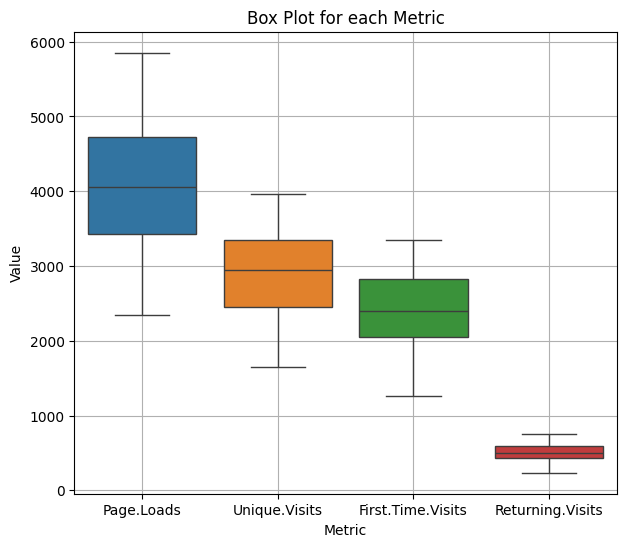

In [7]:
# Detect 'outliers' in the dataset for each metric
plt.figure(figsize=(7, 6))
sns.boxplot(data = df_monthly[metrics])
plt.title('Box Plot for each Metric')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.grid(True)
plt.show()

Based on the outlier detection using `Box Plots`, none of the 4 metrics in this dataset have any outliers.

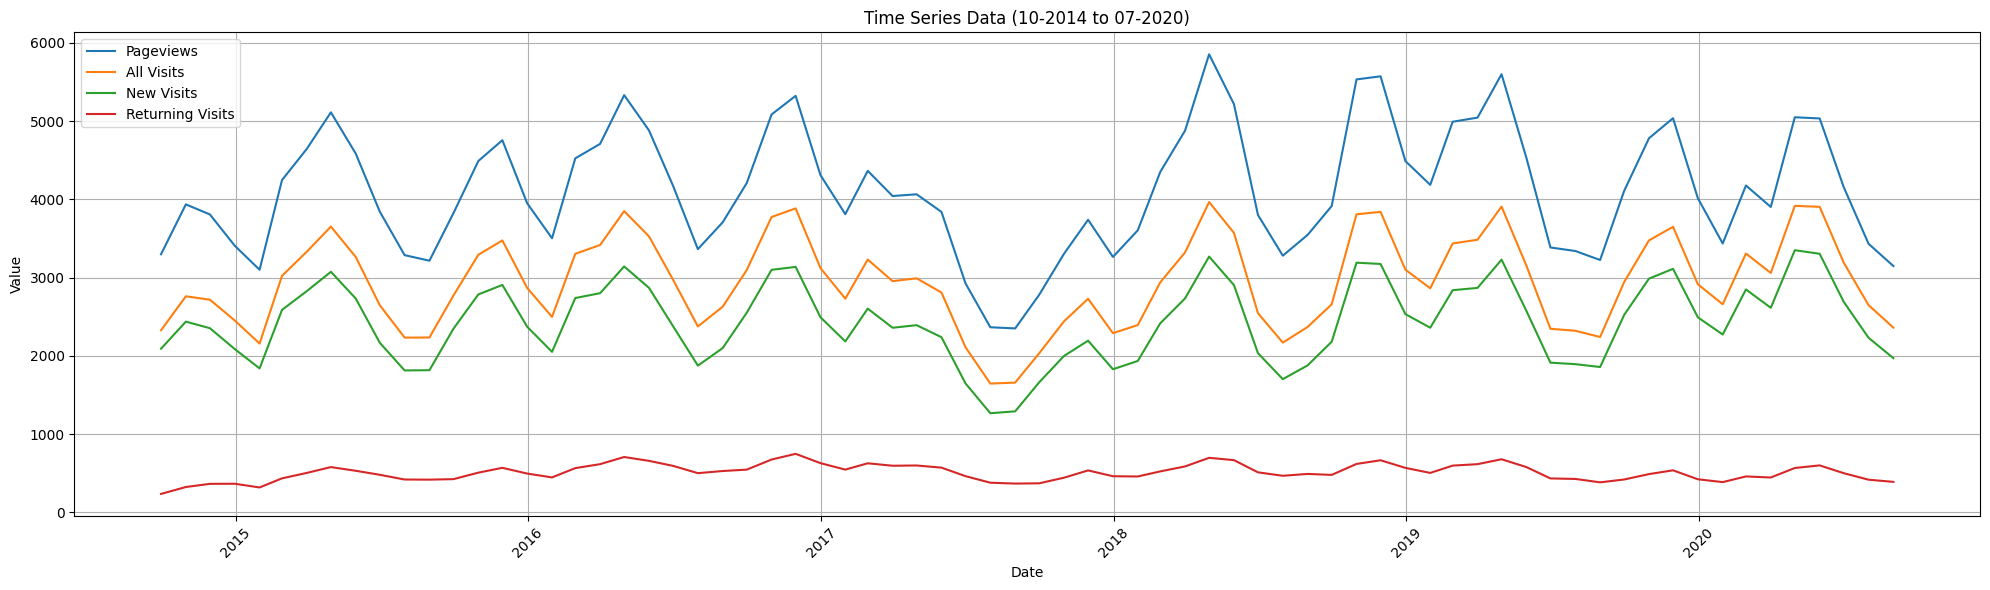

In [8]:
# Visualize time series data for each metric
plt.figure(figsize=(20, 6))
plt.plot(df_monthly['Page.Loads'], label='Pageviews')
plt.plot(df_monthly['Unique.Visits'], label='All Visits')
plt.plot(df_monthly['First.Time.Visits'], label='New Visits')
plt.plot(df_monthly['Returning.Visits'], label='Returning Visits')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.title('Time Series Data (10-2014 to 07-2020)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

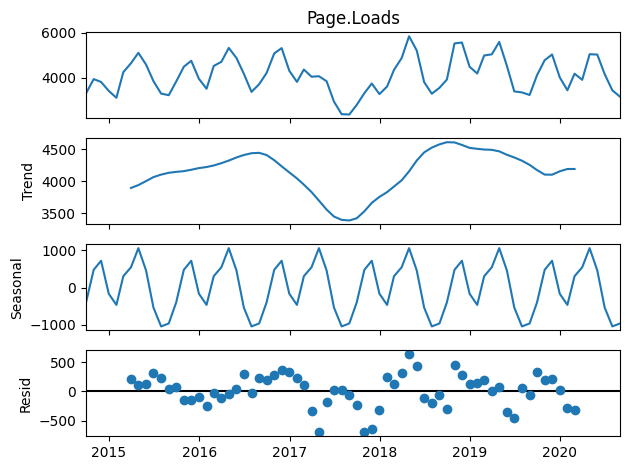

Dickey-Fuller Test of Pageviews
1. ADF :  -3.1658958673084694
2. P-Value :  0.022045592980499455
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


In [10]:
# Decompose time series data for 'Pageviews (Page.Loads)'
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_monthly['Page.Loads'], model='additive', period=12)
decomposition.plot()
plt.show()

# Perform the 'Dickey-Fuller' test to check the 'stationary' properties of Pageviews
from statsmodels.tsa.stattools import adfuller
DF_test = adfuller(df_monthly['Page.Loads'], autolag = 'AIC')
print("Dickey-Fuller Test of Pageviews")
print("1. ADF : ", DF_test[0])
print("2. P-Value : ", DF_test[1])
print("3. Num Of Lags : ", DF_test[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", DF_test[3])
print("5. Critical Values :")
for key, val in DF_test[4].items():
    print("\t",key, ": ", val)

Based on the decomposition of the pageviews time series data, it was determined that the pageviews could exhibit a `trend or seasonality`, which may make them `non-stationary`. Therefore, the Dickey-Fuller test was performed and it can be concluded that `Pageviews has stationary properties at a significance level of 0.05` (the p-value is less than 0.05)

# 4. Data Modeling
Build a forecasting model for `Pageviews` in website visits using the `Box-Jenkins method`

## 4.1 Create Training Dataset & Test Dataset
Divide the dataset into 2 sets: `training set and test set in an 85:15 ratio`. The training set consist of data from September 2014 to October 2019, and the test set include data from November 2019 to August 2020

In [13]:
# Transform data to standardize format (standard normal distribution)
mean_value = np.mean(df_monthly['Page.Loads'])
std_value = np.std(df_monthly['Page.Loads'])
df_monthly['Standardized_Page.Loads'] = (df_monthly['Page.Loads'] - mean_value) / std_value

# Split the dataset into 2 sets
test_size = 0.15
n_test = int(len(df_monthly) * test_size)
train_set = df_monthly[:-n_test]
train_set = train_set[['Standardized_Page.Loads']]
test_set = df_monthly[-n_test:]
test_set = test_set[['Standardized_Page.Loads']]

## 4.2 Hyperparameter Tuning
Plot `Autocorrelation (ACF)` and `Partial Autocorrelation (PACF)` to identify potential parameters and find the optimal set of parameters for this dataset using the AIC criterion

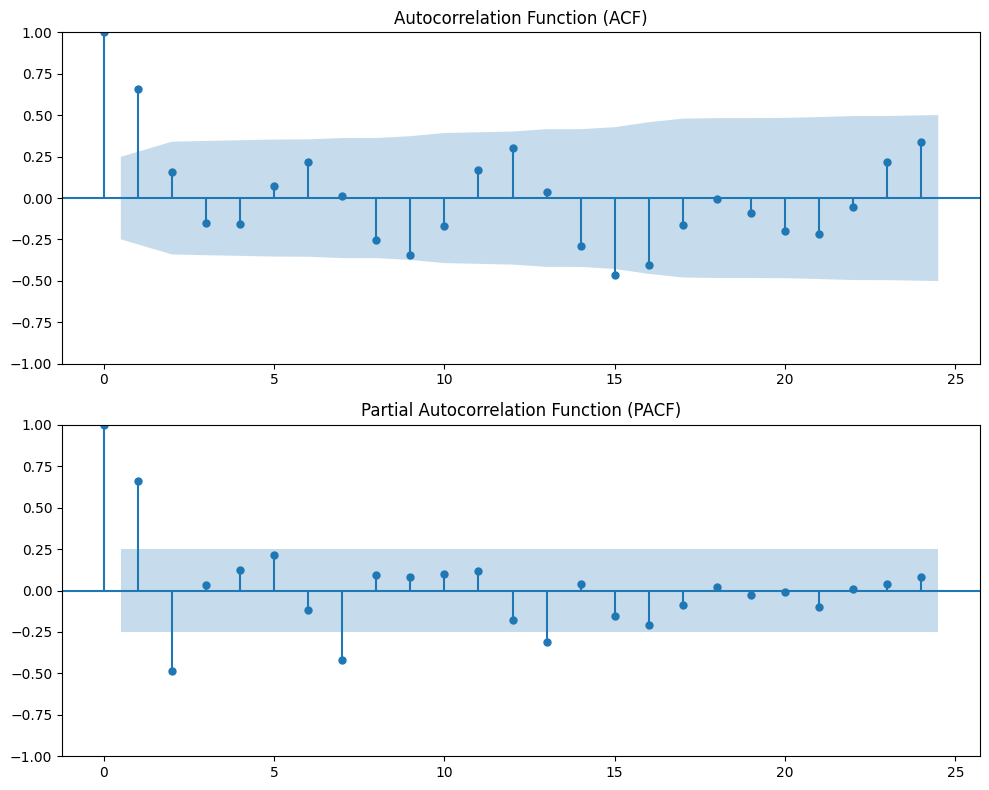

In [14]:
# Plot Autocorrelation (ACF) & Partial Autocorrelation (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_set, lags=24, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(train_set, lags=24, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [18]:
# Find the optimal set of 'parameters' for this dataset
import pmdarima as pmd
model = pmd.auto_arima(train_set , start_p=1, start_q=1, test='adf', m=12, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=108.617, Time=0.08 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=88.613, Time=0.30 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=97.821, Time=0.10 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=89.610, Time=1.00 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=89.135, Time=0.72 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=87.212, Time=0.41 sec
 ARIMA(1,2,0)(0,1,2)[12]             : AIC=89.150, Time=0.72 sec
 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=6.22 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=99.641, Time=0.39 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(2,2,1)(0,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(1,2,0)(0,1,1)[12] intercept   : AIC=89.152, Time=0.45 sec

Based on the calculation of AIC values for each model with different number of parameters, it was determined that the most effective model for this dataset is `ARIMA(1, 2, 0) (0, 1, 1) [12]` as it has `the lowest AIC value of 88.613`.

## 4.3 Training & Test Model
Build a forecasting model using the `Seasonal ARIMA (SARIMA)` algorithm with parameters set to `SARIMA (1, 2, 0) x (0, 1, 1) [12]`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


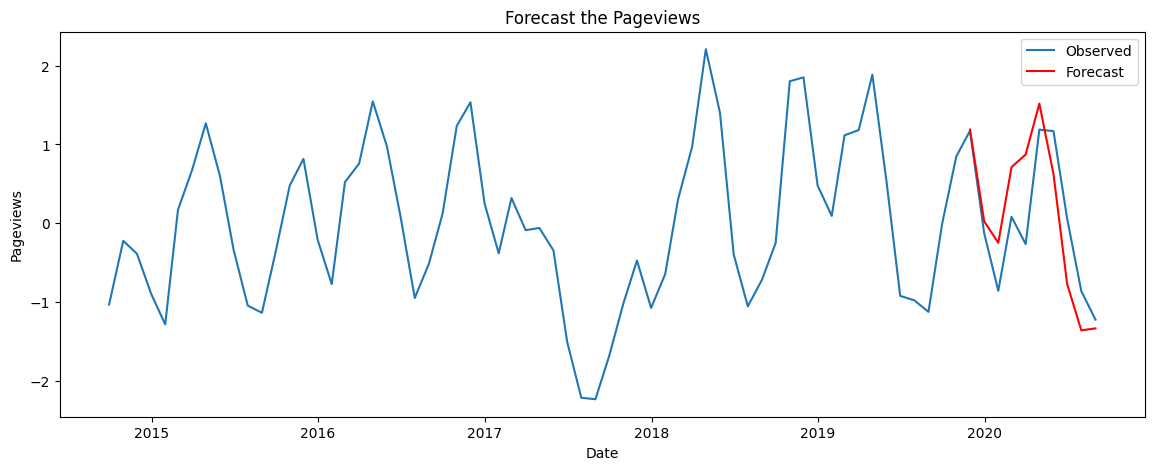

Mean Absolute Percentage Error (MAPE): 3.0019


In [22]:
# Training model
from statsmodels.tsa.statespace.sarimax import SARIMAX
p, d, q = 1, 2, 0
P, D, Q, s = 0, 1, 1, 12

model_SARIMA = SARIMAX(train_set, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model_SARIMA.fit()

# Forecast the next 10 months (test set)
forecast_periods = 10
forecast = model_fit.get_forecast(steps = forecast_periods)
forecast_mean = forecast.predicted_mean

# Visualize to compare observed and forecast
plt.figure(figsize=(14, 5))
plt.plot(df_monthly['Standardized_Page.Loads'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.title("Forecast the Pageviews")
plt.xlabel("Date")
plt.ylabel("Pageviews")
plt.legend()
plt.show()

# Evaluate model performance using 'Mean Absolute Percentage Error (MAPE)'
from sklearn.metrics import mean_absolute_percentage_error
observed = df_monthly['Standardized_Page.Loads'][-forecast_periods:]
mape = mean_absolute_percentage_error(observed, forecast_mean).round(4)
print('Mean Absolute Percentage Error (MAPE):', mape)

In [23]:
# Examine the parameter coefficients of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:              Standardized_Page.Loads   No. Observations:                   62
Model:             SARIMAX(1, 2, 0)x(0, 1, [1], 12)   Log Likelihood                 -40.606
Date:                              Wed, 01 May 2024   AIC                             87.212
Time:                                      16:59:53   BIC                             92.825
Sample:                                  09-30-2014   HQIC                            89.333
                                       - 10-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5181      0.122     -4.244      0.000      -0.757      -0.279
ma.S.L12      -0.69

Upon examining the parameter coefficients of both parameters, namely `ar.L1 and ma.S.L12`, it was found that `both parameters have values not equal to 0 at a significance level of 0.05`.

## 4.4 Examine the appropriateness of the model
This involves testing the properties of the `residuals` in 2 aspects, as follows:

Shapiro-Wilk test p-value: 0.3956046402454376


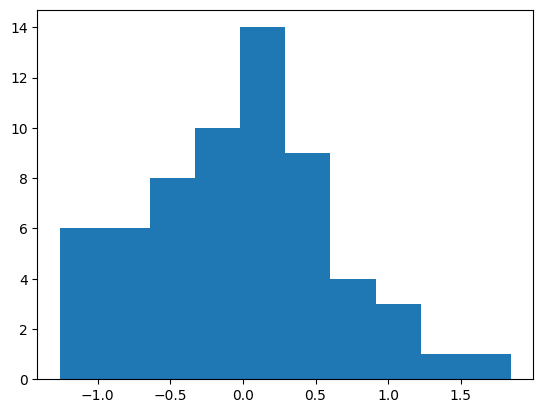

In [25]:
# Examine the distribution of residuals
from scipy.stats import shapiro
residuals = model_fit.resid
stat, p = shapiro(residuals)
print('Shapiro-Wilk test p-value:', p)
plt.hist(residuals)
plt.show()

In [26]:
# Examine the independence between residuals
import statsmodels.api as sm
ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[12], return_df=True)
ljung_box_test

,lb_stat,lb_pvalue
12,16.08666,0.187299


The `Shapiro-Wilk test` and `Ljung-Box test` results indicate that `the residuals are normally distributed and independent of each other at the 0.05 significance level`.

# 5. Deploy Model
Deploy the model to forecast the pageviews from `September to December 2020`.

Forecast the Pageviews (01-2020 to 12-2020)
2020-01-31    3915.481505
2020-02-29    4672.696713
2020-03-31    4798.937617
2020-04-30    5308.521722
2020-05-31    4602.650434
2020-06-30    3501.858722
2020-07-31    3039.609287
2020-08-31    3058.878851
2020-09-30    3607.153824
2020-10-31    4465.365076
2020-11-30    4649.552578
2020-12-31    3787.827819
Freq: M, Name: Page.Loads, dtype: float64


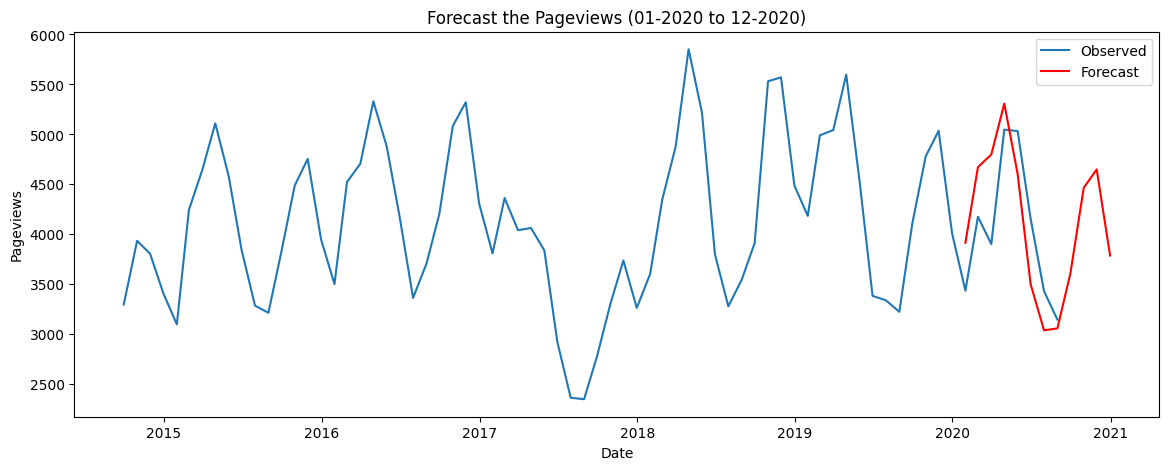

In [28]:
# Forecast the pageviews in 2020
forecast_periods = 14
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean.iloc[-12:]

df_forecast = pd.DataFrame(forecast_mean)
df_forecast.columns = ['Standardized_Page.Loads']
df_forecast['Page.Loads'] = (df_forecast['Standardized_Page.Loads']*std_value) + mean_value
print("Forecast the Pageviews (01-2020 to 12-2020)")
print(df_forecast['Page.Loads'])

# Visualize to show the observed and forecast
plt.figure(figsize=(14, 5))
plt.plot(df_monthly['Page.Loads'], label='Observed')
plt.plot(df_forecast['Page.Loads'], label='Forecast', color='red')
plt.title("Forecast the Pageviews (01-2020 to 12-2020)")
plt.xlabel("Date")
plt.ylabel("Pageviews")
plt.legend()
plt.show()

Applying the model to forecast the pageviews for September to December 2020 resulted in predicted values of `3607.15, 4465.37, 4649.55, and 3787.83 page respectively`.